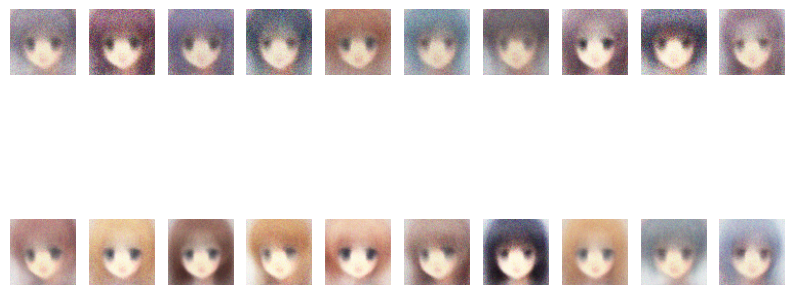

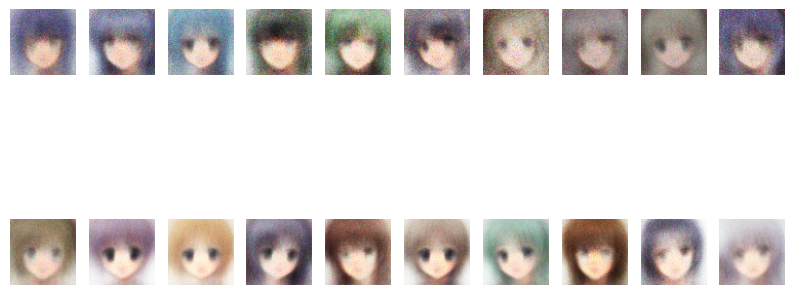

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt  # 导入matplotlib用于显示图像

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义一些超参数
image_size = 64 * 64 * 3  # 假设 ANIME 图片为 64x64 RGB
h_dim = 400
z_dim = 20
num_epochs = 30
batch_size = 128
learning_rate = 0.001

# 数据预处理：调整为符合 ANIME 数据集
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] range
])

# 使用 ImageFolder 加载 ANIME 数据集
dataset = ImageFolder(root=r'D:\code\扩散code\Anime-Face-Dataset-master', transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, image_size=64*64*3, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc4(z))
        return torch.tanh(self.fc5(h))  # Output range [-1, 1] to match normalized input
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 开始训练模型
for epoch in range(num_epochs):
    model.train()
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and KL divergence
        reconst_loss = F.mse_loss(x_reconst, x, reduction='sum')  # 使用 MSE 损失适合像素值的重建
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backpropagation and optimization
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print(f"Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], "
                  f"Reconst Loss: {reconst_loss.item():.4f}, KL Div: {kl_div.item():.4f}")
    
    with torch.no_grad():
        # 保存采样图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 3, 64, 64)
        
        # 显示生成图像
        plt.figure(figsize=(10, 5))
        for j in range(10):  # 显示10张生成的图像
            plt.subplot(2, 10, j + 1)
            plt.imshow(out[j].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  # 反归一化
            plt.axis('off')
        
        # 显示重构图像
        out_reconst, _, _ = model(x)
        out_reconst = out_reconst.view(-1, 3, 64, 64)  # 确保重构图像的形状正确
        
        for j in range(10):  # 显示10张重构图像
            plt.subplot(2, 10, j + 11)
            plt.imshow(out_reconst[j].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  # 反归一化
            plt.axis('off')
        
        plt.show()  # 显示所有图像
